<a href="https://colab.research.google.com/github/YaroslavRy/VoiceVAE/blob/master/SpectrogramVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
 
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from scipy.io import wavfile
from tqdm import tqdm

import librosa
import librosa.display
import pickle
# from config import PATH_SPECTROGRAMS_PICKLED, 
from IPython.display import  Audio
from IPython.display import set_matplotlib_formats
import shutil
set_matplotlib_formats('jpg')
plt.style.use('seaborn')

import gc

In [ ]:
BASE_AUDIO_PATH = 'AudioMNIST/data'
AUDIO_PATH = 'data'

## Load audio

In [ ]:
!git clone https://github.com/soerenab/AudioMNIST.git

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30119, done.
remote: Total 30119 (delta 0), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30119/30119), 944.54 MiB | 23.38 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (30018/30018), done.


In [ ]:
!ls AudioMNIST/data

01  05	09  13	17  21	25  29	33  37	41  45	49  53	57  audioMNIST_meta.txt
02  06	10  14	18  22	26  30	34  38	42  46	50  54	58
03  07	11  15	19  23	27  31	35  39	43  47	51  55	59
04  08	12  16	20  24	28  32	36  40	44  48	52  56	60


In [ ]:
!mkdir data

In [ ]:

for d in tqdm(os.listdir(BASE_AUDIO_PATH)):
  current_folder_path = os.path.join(BASE_AUDIO_PATH, d)
  if os.path.isdir(current_folder_path):
    for f in os.listdir(current_folder_path):
      wav_file = wavfile.read(os.path.join(current_folder_path, f))
      shutil.copy(os.path.join(current_folder_path, f), os.path.join(AUDIO_PATH, f))

100%|██████████| 61/61 [00:26<00:00,  2.34it/s]


In [ ]:
len(os.listdir('data'))

30000

## Preprocess

In [ ]:
SAMPLE_RATE = 44000

In [ ]:
!ls data | head -4 

0_01_0.wav
0_01_10.wav
0_01_11.wav
0_01_12.wav


In [ ]:
sr, wav = wavfile.read(os.path.join(AUDIO_PATH, '5_02_0.wav'))
Audio(wav, rate=sr)

In [ ]:
digit_len_d = {}
for f in os.listdir('data'):
  sr, wav = wavfile.read(os.path.join(AUDIO_PATH, f))
  key = f.split('_')[0]
  digit_len_d.setdefault(key, [len(wav)])
  digit_len_d[f.split('_')[0]].append( len(wav))

Some stats about durations of utterances

In [ ]:
[{x: [np.mean(digit_len_d[x]) /  SAMPLE_RATE, np.max(digit_len_d[x]) / SAMPLE_RATE, len(digit_len_d[x])]} for x in digit_len_d]

[{'5': [0.6907528399624367, 1.0896363636363637, 3001]},
 {'8': [0.6389368771015722, 1.0270681818181817, 3001]},
 {'9': [0.7290480748841295, 1.0849772727272726, 3001]},
 {'0': [0.7751080700372602, 1.0908636363636364, 3001]},
 {'1': [0.6455033700887582, 1.05775, 3001]},
 {'7': [0.8022698570173578, 1.08875, 3001]},
 {'2': [0.6056240798521705, 1.040340909090909, 3001]},
 {'4': [0.6649390354730241, 1.0832954545454545, 3001]},
 {'3': [0.6581893838417497, 1.0860227272727272, 3001]},
 {'6': [0.7997618899760687, 1.09075, 3001]}]

Load to RAM and crop

In [ ]:
seconds = 1
MAX_LEN = SAMPLE_RATE * seconds

In [ ]:
wavs = []
size = 30000
for i, f in enumerate(np.random.choice(os.listdir(AUDIO_PATH), size=size)):
  sr, wav = wavfile.read(os.path.join(AUDIO_PATH, f))
  wavs.append(wav[:MAX_LEN].astype(np.float16))

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "


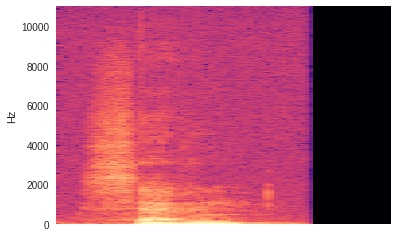

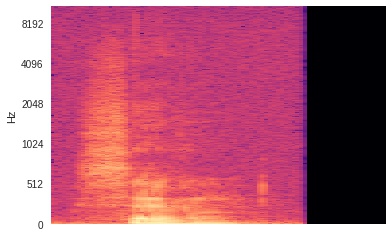

In [ ]:
i = 9
S = librosa.stft(wavs[i])
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, y_axis='linear')
plt.show()
librosa.display.specshow(S_dB, y_axis='mel')
plt.show()

In [ ]:
S = librosa.feature.melspectrogram(S=S_dB, sr=sr)

In [ ]:
S.shape

(128, 64)

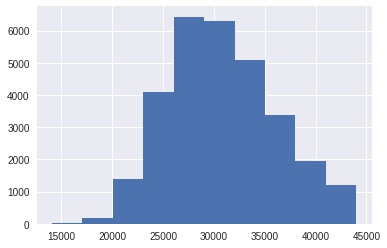

In [ ]:
plt.hist([len(x) for x in wavs]);

### Padding
pad zeroes utterances that are shorten than MAX_LEN

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
wavs = pad_sequences(wavs, maxlen=MAX_LEN, padding='post', value=0.0, dtype=np.float16)

In [ ]:
import pickle

In [ ]:
pickle.dump(wavs, open('data/wavs.pkl', 'wb'))

In [ ]:
wavs = pickle.load(open('data/wavs.pkl', 'rb'))

Save go Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pickle.dump(wavs, open('drive/MyDrive/wavs.pkl', 'wb'))

In [ ]:
wavs = pickle.load(open('drive/MyDrive/wavs.pkl', 'rb'))

### Get spectrograms from wavs

In [ ]:
spectrograms = []
for wav in tqdm(wavs):
  S = librosa.stft(wav)
  S_dB = librosa.power_to_db(S, ref=np.max)
  spectrograms.append(S_dB.astype(np.float16))

  0%|          | 0/30000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1545: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  "power_to_db was called on complex input so phase "
100%|██████████| 30000/30000 [09:46<00:00, 51.17it/s] 


In [ ]:
del wavs

In [ ]:
gc.collect()

88

In [ ]:
pickle.dump(spectrograms, open('drive/MyDrive/spectrograms.pkl', 'wb'))

In [ ]:
librosa.spechow(spectrograms[0])

## Pytorch model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
batch_size = 128

In [ ]:
# N,C,in,,H,W

In [ ]:
dataloader = torch.utils.data.DataLoader(wavs, batch_size=batch_size, shuffle=False)
len(dataloader)

235

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [ ]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x.to(device), x.to(device), size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [ ]:
from torchsummary import summary

In [ ]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            # nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),
            # nn.ReLU(),
            # nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            # nn.ReLU(),
            # nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [ ]:
model = VAE(image_channels=1).double() # .cuda()
model 

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(3, 3), stride=(2, 2))
    (2): ReLU()
    (3): Sigmoid()
  )
)

In [ ]:
summary(model.encoder.float(), input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             160
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3           [-1, 64, 64, 64]           8,256
              ReLU-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 32, 32]          32,896
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         131,328
              ReLU-8          [-1, 256, 16, 16]               0
           Flatten-9                [-1, 65536]               0
Total params: 172,640
Trainable params: 172,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 15.50
Params size (MB): 0.66
Estimated Total Size (MB): 16.41
-----------------------------------------

In [ ]:
model.encode(images.to(device))

NameError: ignored

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

1451808

In [ ]:
epochs = 10
for epoch in range(epochs):
    for idx, images in enumerate(dataloader):
        recon_images, mu, logvar = model.double()(images.to(device))
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.item()/batch_size, bce.item()/batch_size, kld.item()/batch_size)
        print(to_print)

RuntimeError: ignored

In [ ]:
recon_images[0].cpu().detach().numpy().shape

(1, 32, 32)

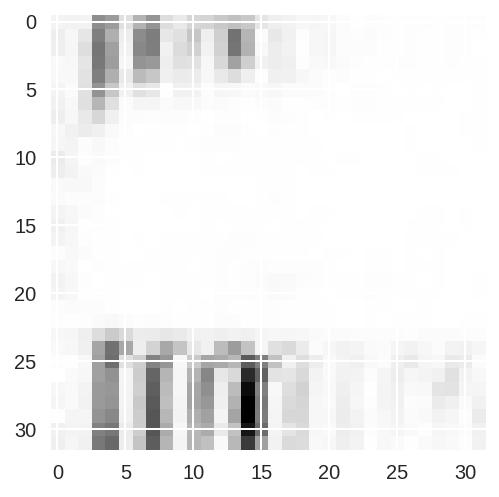

In [ ]:
plt.imshow(x_train_padded[11][0, :, :])

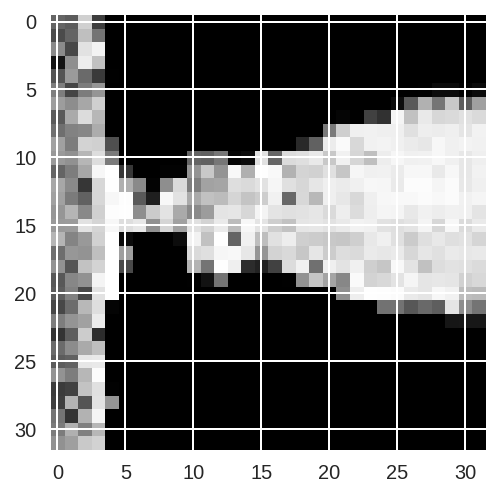

In [ ]:
plt.imshow(recon_images[11].cpu().detach().numpy()[0, :, :])